In [1]:
import browser_cookie3
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 97.0.4692
[WDM] - Get LATEST driver version for 97.0.4692
[WDM] - Driver [/Users/jay/.wdm/drivers/chromedriver/mac64/97.0.4692.71/chromedriver] found in cache


In [3]:
driver.get("https://naver.com")

로그인을 위해 기존 크롬 브라우저의 쿠키 가져와 주입한다.

In [4]:
for c in browser_cookie3.chrome():
    if c.domain == ".naver.com":
        cookie = {
            "domain": c.domain,
            "name": c.name,
            "value": c.value,
        }
        if c.expires:
            cookie["expiry"] = c.expires
        if c.path_specified:
            cookie["path"] = c.path
        driver.add_cookie(cookie)

In [5]:
driver.get("https://brand.naver.com/xbox/products/5311833860") # 물량이 남은 xbox series s...

In [6]:
driver.find_element("xpath", "//span[text()='구매하기']/parent::a").click()

In [7]:
driver.find_element("xpath", "//button[text()='결제하기']").click()

<img src="https://i.imgur.com/f8Y3Z3G.png" alt="네이버페이" width="400"/>

In [8]:
driver.switch_to.window(driver.window_handles[1])

In [9]:
css_data = driver.find_element('xpath', '//span[contains(@class, "SecureKeyboard")]').get_attribute("style")
css_data[:100] + "..." + css_data[-100:]

'background-image: url("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAHgAAADICAYAAAAjriWnAAAS1klEQVR...f0sUwJ7oBNiXP90HsfqwdrsaeSz+iq+PxA4vwmJ/teGz6aqwp7i+lInuKwWAwGAwGgxEI/wey49jaz0TuSQAAAABJRU5ErkJg");'

In [10]:
img_data = css_data[css_data.find(',') + 1:css_data.rfind('"')]
img_data[:100] + "..." + img_data[-100:]

'iVBORw0KGgoAAAANSUhEUgAAAHgAAADICAYAAAAjriWnAAAS1klEQVR42u1dC7hPVRa/7nW95YbJq6iRUrklNPJoSiSEPEseqYhJ...F1Ef0sUwJ7oBNiXP90HsfqwdrsaeSz+iq+PxA4vwmJ/teGz6aqwp7i+lInuKwWAwGAwGgxEI/wey49jaz0TuSQAAAABJRU5ErkJg'

In [12]:
import base64

img_name = "keypad.png"

with open(img_name, "wb") as f:
    f.write(base64.b64decode(img_data.encode('ascii')))

In [13]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

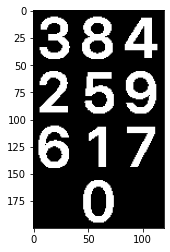

In [14]:
# img = cv2.imread("keypad.png", cv2.IMREAD_COLOR) 이미지가 열릴 때가 있고 아닐 때가 있는데 왜 그럴까..
img = np.asarray(Image.open(img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")

일렬로 나열했을 때 인식률이 높은 것 같다.

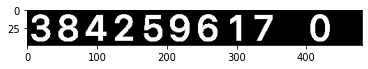

In [15]:
transformed_img = np.concatenate((img[:50], img[50:100]), axis=1)
transformed_img = np.concatenate((transformed_img, img[100:150]), axis=1)
transformed_img = np.concatenate((transformed_img, img[150:200]), axis=1)
plt.imshow(transformed_img, cmap="gray")
plt.show()

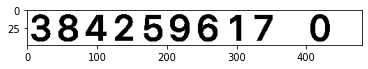

In [16]:
inverted_img = 255 - transformed_img
plt.imshow(inverted_img, cmap="gray")

In [17]:
import pytesseract

text = pytesseract.image_to_string(inverted_img, config='--psm 7 -c tessedit_char_whitelist=0123456789')
text

'3842596170\n\x0c'

In [18]:
import re

numbers = list(re.sub(r'[^0-9]', '', text))
numbers

['3', '8', '4', '2', '5', '9', '6', '1', '7', '0']

인식한 이미지의 숫자 위치를 기반으로 키패드를 클릭하여 결제한다.

In [19]:
keypads = driver.find_elements('xpath', '//span[contains(@class, "SecureKeyboard")]')

for k in keypads:
    print(k.get_attribute('class'))

SecureKeyboard_number__12ZC8 SecureKeyboard_key-1-1__3biwN
SecureKeyboard_number__12ZC8 SecureKeyboard_key-1-2__1Rk6d
SecureKeyboard_number__12ZC8 SecureKeyboard_key-1-3__2TmUv
SecureKeyboard_number__12ZC8 SecureKeyboard_key-2-1__1QUfq
SecureKeyboard_number__12ZC8 SecureKeyboard_key-2-2__1ceFR
SecureKeyboard_number__12ZC8 SecureKeyboard_key-2-3__1mUE-
SecureKeyboard_number__12ZC8 SecureKeyboard_key-3-1__8S-uB
SecureKeyboard_number__12ZC8 SecureKeyboard_key-3-2__7TxUE
SecureKeyboard_number__12ZC8 SecureKeyboard_key-3-3__35VDa
SecureKeyboard_number__12ZC8 SecureKeyboard_key-4-2__XiUgx


In [20]:
for x in '123456': # random password
    keypads[numbers.index(x)].click()